### NLP Disaster Tweets

Determine if tweet is about real disaster (output 1 if so) or not (then output 0) - Classification task. Competition link can be found [here](https://www.kaggle.com/competitions/nlp-getting-started/overview)<br>

#### Evaluation
Use F1 score to evaluate where $$F1 = 2*\frac{precision*recall}{precision+recall}$$ and precision is defined by $$precision = \frac{TP}{TP+FP}$$ and recall defined by $$recall = \frac{TP}{TP+FN}$$

In [1]:
# Firstly lets download dataset:
from pathlib import Path
import os

path = Path('nlp-getting-started')

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    # if on kaggle we assume we already have data in the directory
    !pip install -Uqq fastai # TODO if on a kaggle notebook (this won't work when we go offline though :/)
elif not os.path.exists(path):
    import zipfile,kaggle
    !kaggle competitions download -c nlp-getting-started
    zipfile.ZipFile(f'{path}.zip').extractall(path)    

In [2]:
! pip install -Uqq fastai

In [3]:
# Import stuff you need:
from fastai.imports import *

#### EDA
lets figure some things out about our data to see what kind of validation set we ought to build and what features may be important to us

In [4]:
if iskaggle: path = Path('../input/us-patent-phrase-to-phrase-matching')
path.ls()

(#3) [Path('nlp-getting-started/sample_submission.csv'),Path('nlp-getting-started/train.csv'),Path('nlp-getting-started/test.csv')]

In [5]:
df = pd.read_csv(path/'train.csv')
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1


In [6]:
# Looking at the tweets, just off intuition I would think that words with hashtags # or @ symbols should be treated
# slightly differently, maybe we can incorporate this thinking while we iterate on our model
# I also see some strange characters that may not be useful in the data and may just throw the model off (i.e. M1.94, 
# MontrÌ©al, QuÌ©bec, ÌÏT)
eval_df = pd.read_csv(path/'test.csv')
print(len(eval_df))
eval_df

3263


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city&amp;3others hardest hit. My yard looks like it was bombed. Around 20000K still without power
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/UtbXLcBIuY
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3


In [7]:
df.keyword.value_counts()

keyword
fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64

In [8]:
df.location.value_counts()

location
USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: count, Length: 3341, dtype: int64

In [9]:
# We see that some texts are actually repeated in the dataset, definitely don't want some to be in training, some in 
# validation so we should make sure all repeated texts are in one or the other (no duplicates) so that it gives us a better
# idea as to whether or not our model is actually doing better
df.text.value_counts()

text
11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...        10
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam                      6
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'                               6
#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_     6
Madhya Pradesh Train Derailment: Village Youth Saved Many Lives                                                                                  5
                                                                                                                                                ..
Escape The Heat (and the #ORShow) for a trail run on Desolation Loop you'll be glad you did http://t.co/n2ucNzh38

<Axes: >

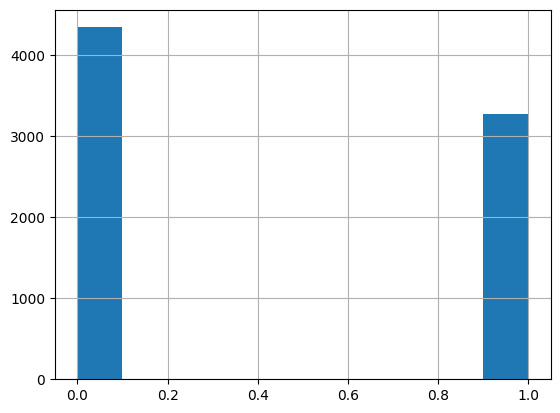

In [10]:
# This is interesting as based off first and last 5 entries of df I assumed 1 was much more common
# May want to shuffle all of the indices around
df.target.hist()

### Training setup
We will use transformers library + smaller pretrained model so we can do a bunch of iterations to see what changes are the best at affecting our metric (F1 score). 

In [11]:
import warnings,transformers,logging,torch
from transformers import TrainingArguments,Trainer
from transformers import AutoModelForSequenceClassification,AutoTokenizer

In [12]:
if iskaggle:
    !pip install -q datasets
import datasets
from datasets import load_dataset, Dataset, DatasetDict

In [13]:
# this will quiet a lot of hugging face warnings and verbosity
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [14]:
# define a small simple model 
model_nm = 'distilbert/distilbert-base-uncased'

In [15]:
# use autotokenizer to look at its vocab and see how
tokz = AutoTokenizer.from_pretrained(model_nm)

In [16]:
# need to come up with a way to combine keyword, location, and text, for now can just do this with separator token
sep = tokz.sep_token
df['inputs'] = f'keyword: {df.keyword}{sep} location: {df.location}{sep} text: {df.text}'


In [17]:
ds = Dataset.from_pandas(df).rename_column('target', 'label') # df -> hf dataset, and rename to label so we can use for training
eval_ds = Dataset.from_pandas(eval_df)

def tokenize(x): return tokz(x['inputs'])
    

In [18]:
tokenize(ds[0]), ds[0] # tokenizer seems to be working well

({'input_ids': [101, 3145, 18351, 1024, 1014, 16660, 1015, 16660, 1016, 16660, 1017, 16660, 1018, 16660, 1012, 1012, 1012, 24643, 2620, 16660, 24643, 2683, 16660, 6146, 10790, 16660, 6146, 14526, 16660, 6146, 12521, 16660, 2171, 1024, 3145, 18351, 1010, 3091, 1024, 6146, 17134, 1010, 26718, 18863, 1024, 4874, 102, 3295, 1024, 1014, 16660, 1015, 16660, 1016, 16660, 1017, 16660, 1018, 16660, 1012, 1012, 1012, 24643, 2620, 16660, 24643, 2683, 16660, 6146, 10790, 16660, 6146, 14526, 16660, 6146, 12521, 16660, 2171, 1024, 3295, 1010, 3091, 1024, 6146, 17134, 1010, 26718, 18863, 1024, 4874, 102, 3793, 1024, 1014, 2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035, 1015, 3224, 2543, 2379, 2474, 6902, 3351, 21871, 2243, 1012, 2710, 1016, 2035, 3901, 2356, 2000, 1005, 7713, 1999, 2173, 1005, 2024, 2108, 19488, 2011, 3738, 1012, 2053, 2060, 13982, 2030, 7713, 1999, 2173, 4449, 2024, 3517, 1017, 2410, 1010, 2199, 2111, 4374, 1001, 3748, 26332, 13982, 4449, 1999, 

In [19]:
# Take out all of these extra attributes as no longer needed, all data was put into inputs, inputs was tokenized, tokens are all
# the input data we need for NLP model
inps = 'keyword', 'location', 'text', 'id', 'inputs' 
tok_ds = ds.map(tokenize, batched=True, remove_columns=inps)

tok_ds[0]

Map:   0%|          | 0/7613 [00:00<?, ? examples/s]

{'label': 1,
 'input_ids': [101,
  3145,
  18351,
  1024,
  1014,
  16660,
  1015,
  16660,
  1016,
  16660,
  1017,
  16660,
  1018,
  16660,
  1012,
  1012,
  1012,
  24643,
  2620,
  16660,
  24643,
  2683,
  16660,
  6146,
  10790,
  16660,
  6146,
  14526,
  16660,
  6146,
  12521,
  16660,
  2171,
  1024,
  3145,
  18351,
  1010,
  3091,
  1024,
  6146,
  17134,
  1010,
  26718,
  18863,
  1024,
  4874,
  102,
  3295,
  1024,
  1014,
  16660,
  1015,
  16660,
  1016,
  16660,
  1017,
  16660,
  1018,
  16660,
  1012,
  1012,
  1012,
  24643,
  2620,
  16660,
  24643,
  2683,
  16660,
  6146,
  10790,
  16660,
  6146,
  14526,
  16660,
  6146,
  12521,
  16660,
  2171,
  1024,
  3295,
  1010,
  3091,
  1024,
  6146,
  17134,
  1010,
  26718,
  18863,
  1024,
  4874,
  102,
  3793,
  1024,
  1014,
  2256,
  15616,
  2024,
  1996,
  3114,
  1997,
  2023,
  1001,
  8372,
  2089,
  16455,
  9641,
  2149,
  2035,
  1015,
  3224,
  2543,
  2379,
  2474,
  6902,
  3351,
  21871,
  2243,


### Validation set

Seems like the best thing to do is probably just get a sample for validation set, maybe not including the same text? Or maybe with to incorporate recall which is a part of our metric. For now we go for easiest and simplest way

In [20]:
dds = tok_ds.train_test_split(test_size=.25)

### Initial Model
Need to provide a metric, namely the F1 score. Firstly we will define a function that can compute it given preds and true. Then we will create a function that uses this F1 method and passes back a dict so Transformers library can use.

In [21]:
def compute_f1(preds, true):
    preds, true = np.array(preds), np.array(true)
    # ensure they have the same shape
    if preds.shape!=true.shape:
        print(f'shapes: preds: {preds.shape} true: {true.shape}')

    # compute true positives
    TP = np.sum((preds==1) & (true==1))
    # compute false positives
    FP = np.sum((preds==1) & (true==0))
    # compute false negatives
    FN = np.sum((preds==0) & (true==1))

    precision = TP/(TP+FP)
    recall = TP/(TP+FN)

    return (2*precision*recall)/(precision+recall) # f1 formula

bs_preds = np.ones_like(dds['test']['label'])
compute_f1(bs_preds, dds['test']['label']) # Seems to work

0.5859636093575937

In [22]:
def f1(eval_preds): return {'F1':compute_f1(*eval_preds) } # This is the function we will pass to transformers

In [23]:
# Pick reasonable lr, wd, bs, epochs
lr,bs = 8e-5,32
wd,epochs = 0.01,3

In [24]:
# function from fastai grandmaster notebook, look there for more expo
def get_trainer(dds):
    args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
        evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
        num_train_epochs=epochs, weight_decay=wd, report_to='none')
    model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
    return Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                   tokenizer=tokz, compute_metrics=f1)

In [25]:
trainer = get_trainer(dds)

In [26]:
# The reason we are encountering this error, according to stackoverflow, is because our problem is a single label
# is a single label binary classification problem so we need to use a different loss function
# Look at the below link to see that when num_labels==1 its seen as regression, > 1 its thought of as classification
# https://github.com/huggingface/transformers/blob/05fa1a7ac17bb7aa07b9e0c1e138ecb31a28bbfe/src/transformers/models/bert/modeling_bert.py#L1563
trainer.train();

RuntimeError: Found dtype Long but expected Float

In [27]:
# All we are going to change is num_labels lets see what happens:
def get_trainer(dds):
    args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
        evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
        num_train_epochs=epochs, weight_decay=wd, report_to='none')
    model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=2)
    return Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                   tokenizer=tokz, compute_metrics=f1)

trainer=get_trainer(dds)

In [29]:
# getting this error because we don't understand EvalPrediction object transformers returns to help us create metrics for 
# training and inference. 
trainer.train();

Epoch,Training Loss,Validation Loss


shapes: preds: (1904, 2) true: (1904,)


ValueError: operands could not be broadcast together with shapes (1904,2) (1904,) 

In [30]:
# Lets print the Eval prediction object we generate during inference and then recreate our F1 score fn
# WARNING: we have reinitialized trainer to have no compute_metric
trainer.compute_metrics=None
eval_pred = trainer.predict(test_dataset=dds['test'].select(range(10))) # run predictions on small subset of validation set
eval_pred

PredictionOutput(predictions=array([[ 0.08377087, -0.07733025],
       [ 0.08377087, -0.07733025],
       [ 0.08377087, -0.07733025],
       [ 0.08377087, -0.07733025],
       [ 0.08377087, -0.07733025],
       [ 0.08377087, -0.07733025],
       [ 0.08377087, -0.07733025],
       [ 0.08377087, -0.07733025],
       [ 0.08377087, -0.07733025],
       [ 0.08377089, -0.07733027]], dtype=float32), label_ids=array([1, 0, 1, 1, 0, 1, 1, 0, 1, 1]), metrics={'test_loss': 0.7366630434989929, 'test_runtime': 0.1396, 'test_samples_per_second': 71.614, 'test_steps_per_second': 7.161})

As you can see the predictions are a 2D array. After doing some research, the numbers for each index (row) of the predictions array represent the raw logits of the model for each class.
 - If we had more classes (categories), we would have more columns
 - We feed these logits through a softmax to get the probabilities of the model
 - To get the actual predictions (i.e whether for example 1 we predict it to be in class 0 or 1) we need to take the argmax along axis 1 (along the columns)
 - This is because applying softmax doesn't change relative order of the logits/probabilities

In [31]:
# rewriting our F1 function:
# Going to use scikit learn function to handle all edge cases for us too
from sklearn.metrics import f1_score
def compute_f1(preds, true):
    preds, true = np.array(preds), np.array(true)
    # Applying argmax as we talked about above
    preds = np.argmax(preds, axis=1)  
    # Use external library 
    return f1_score(true, preds)

def f1(eval_preds): return {'F1':compute_f1(*eval_preds) }

In [32]:
trainer = get_trainer(dds)

trainer.train();

Epoch,Training Loss,Validation Loss,F1
1,No log,0.683222,0.000000


KeyboardInterrupt: 

In [ ]:
# Lets try to troubleshoot why F1 is always 0
eval_predictions = trainer.predict(test_dataset=dds['test'].select(range(10)))
pred_labels = np.argmax(eval_predictions.predictions, axis=1)
print("Predicted Labels Distribution:", np.bincount(pred_labels), np.bincount(eval_predictions.label_ids))
print(eval_predictions.predictions)
# So it seems that its only predicting 0, likely bc we initialized model with AutoModelForSequenceClassification

In [ ]:
# lets try to just make learning rate smaller and try again, maybe because this model is bigger than deberta small?
lr,bs = 8e-7,16
wd,epochs = 0.01,3

trainer = get_trainer(dds)
trainer.train();

In [ ]:
# maybe I don't understand something about BERT? lets try different model
model_nm = 'microsoft/deberta-v3-small'

trainer = get_trainer(dds)
trainer.model.config._name_or_path

In [ ]:
trainer.train();

In [33]:
from datasets import Value
# Trying changing problem type and casting labels to floats
def get_trainer(dds):
    args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine',
                             fp16=True, evaluation_strategy="epoch", per_device_train_batch_size=bs, 
                             per_device_eval_batch_size=bs*2, num_train_epochs=epochs, weight_decay=wd, report_to='none')
    
    model = AutoModelForSequenceClassification.from_pretrained(model_nm, 
                                                               num_labels=1,
                                                               problem_type = "single_label_classification")
    return Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                   tokenizer=tokz, compute_metrics=f1)

new_features = dds['test'].features.copy()
new_features['label']=Value(dtype='float32')

f_dds = dds.cast(new_features)
f_dds['train'].features

trainer = get_trainer(dds)

Casting the dataset:   0%|          | 0/5709 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1904 [00:00<?, ? examples/s]

In [37]:
trainer.train();

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
